In [1]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from python_tsp.heuristics import solve_tsp_local_search
import time


In [5]:
rng = np.random.default_rng()

In [3]:
from alora.astroutils import ObsConstraint
from alora.astroutils.observing_utils import current_dt_utc, ang_sep

In [4]:
obs_constraint = ObsConstraint()

In [6]:
lst = obs_constraint.get_obs_lst()

In [8]:
lst.to_value("hourangle")

np.float64(22.303663879982796)

In [8]:
obs_constraint.get_hour_angle_limits(0)

(<Angle -60. deg>, <Angle 60. deg>)

In [9]:
NSAMPLES = 10

In [10]:
# RAS = rng.uniform(-180,180,int(2*np.sqrt(NSAMPLES)))
# DECS = rng.uniform(-90,90,int(2*np.sqrt(NSAMPLES)))

In [11]:
coords = []
t=current_dt_utc()
lst = obs_constraint.get_obs_lst()
while len(coords) < NSAMPLES:
    ra = rng.uniform(0,360)
    dec = rng.uniform(-90,90)
    if obs_constraint.observation_viable(dt=t,ra=ra*u.deg,dec=dec*u.deg, current_sidereal_time=lst):
        coords.append((ra,dec))
coords

[(12.767155885877393, -21.083957341477884),
 (48.615432037093804, 29.074571632280836),
 (130.3317914796615, 72.81962632075042),
 (209.1175019781971, 79.40455845473093),
 (1.9745802453515093, 54.92172095848787),
 (324.82498446234933, -4.489943977925961),
 (80.94140035098057, 35.44973901489634),
 (133.9598807536226, 82.54734701088395),
 (302.7824517841185, 71.96240477833476),
 (297.9721153196399, 12.134432138994228)]

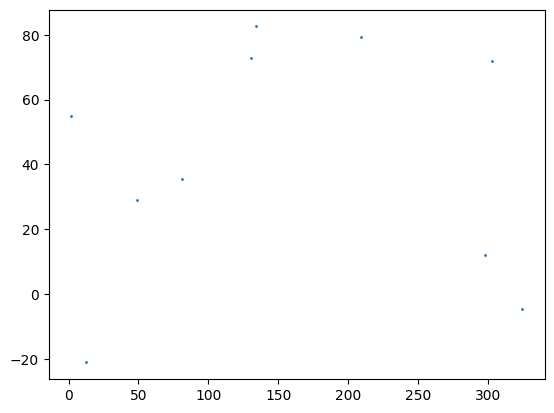

In [12]:
plt.scatter(np.array(coords)[:,0],np.array(coords)[:,1],s=1)

In [13]:
FIELD_WIDTH = 24.4 #arcmin 
FIELD_HEIGHT = 18.5 # arcmin

FIELD_WIDTH /= 60
FIELD_HEIGHT /= 60

MAG_LIM = 11
RADIUS = 0.5  # search radius, degrees

In [14]:
RA = 10.684
DEC = 41.268
coord = SkyCoord(RA*u.deg,DEC*u.deg)


In [15]:
best_ras, best_decs, best_nums = [], [], []

In [16]:
for RA, DEC in coords:
    query = f"""
    SELECT
    source_id,
    ra,
    dec,
    phot_g_mean_mag
    FROM
    gaiadr3.gaia_source
    WHERE
    1=CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {RA}, {DEC}, {RADIUS})
    )
    AND phot_g_mean_mag < {MAG_LIM}
    """

    print(f"querying {RADIUS} degrees around {RA},{DEC}")
    job = Gaia.launch_job(query)

    results = job.get_results()
    print(f"Found {len(results)} stars with mag < {MAG_LIM}")
    # results

    RESOLUTION = 50

    ras = np.linspace(RA-RADIUS,RA+RADIUS, RESOLUTION)
    decs = np.linspace(DEC-RADIUS,DEC+RADIUS, RESOLUTION)

    nums = np.empty((len(ras),len(decs)))


    best_num = 0
    best_ra, best_dec = None, None
    for i, ra in enumerate(ras):
        for j, dec in enumerate(decs):
            n_in_box = np.sum((results["ra"] >= ra-0.5*FIELD_WIDTH) & (results["ra"] <= ra+0.5*FIELD_WIDTH) & (results["dec"] >= dec-0.5*FIELD_HEIGHT) & (results["dec"] <= dec + 0.5*FIELD_HEIGHT))
            nums[i,j] = n_in_box
            if n_in_box > best_num:
                best_ra = ra
                best_dec = dec
                best_num = n_in_box

    print(f"Best spot: ({best_ra}, {best_dec}): {best_num} sources")
    best_ras.append(best_ra)
    best_decs.append(best_dec)
    best_nums.append(best_num)

fields = Table()
fields["ra"] = best_ras 
fields["dec"] = best_decs
fields["n_bright"] = best_nums
fields

querying 0.5 degrees around 12.767155885877393,-21.083957341477884
Found 12 stars with mag < 11
Best spot: (12.430421191999843, -21.053345096579925): 5 sources
querying 0.5 degrees around 48.615432037093804,29.074571632280836
Found 9 stars with mag < 11
Best spot: (48.46237081260401, 28.799061428199202): 4 sources
querying 0.5 degrees around 130.3317914796615,72.81962632075042
Found 20 stars with mag < 11
Best spot: (129.93383229598803, 72.72778958605655): 4 sources
querying 0.5 degrees around 209.1175019781971,79.40455845473093
Found 14 stars with mag < 11
Best spot: (208.82158361085018, 79.10864008738399): 3 sources
querying 0.5 degrees around 1.9745802453515093,54.92172095848787
Found 49 stars with mag < 11
Best spot: (1.6174373882086521, 54.62580259114093): 10 sources
querying 0.5 degrees around 324.82498446234933,-4.489943977925961
Found 12 stars with mag < 11
Best spot: (325.05967833990036, -4.806270508538206): 4 sources
querying 0.5 degrees around 80.94140035098057,35.4497390148

ra,dec,n_bright
float64,float64,int64
12.430421191999843,-21.053345096579925,5
48.46237081260401,28.799061428199202,4
129.93383229598803,72.72778958605655,4
208.82158361085018,79.10864008738399,3
1.6174373882086521,54.62580259114093,10
325.05967833990036,-4.806270508538206,4
80.82915545302139,35.62320840265144,9
133.54151340668383,82.21061231700641,2
302.4049007637103,71.66648641098782,4


In [24]:
c = SkyCoord(fields["ra"]*u.deg,fields["dec"]*u.deg)

In [33]:
def dist_matrix(coords:SkyCoord):
    M = np.zeros((len(coords), len(coords)))
    indices = range(len(coords))
    for i in indices:
        for j in indices:
            if i < j:
                s1, s2 = coords[i], coords[j]
                t = ang_sep(s1,s2).to_value("degree")
                M[i, j] = M[j, i] = t
    # because we're solving tsp but not returning to beginning: 
    M[:, 0] = 0
    return M

In [36]:
M = dist_matrix(c)
start = time.perf_counter()
permutation, distance = solve_tsp_local_search(M)
print(f"Solved with n={len(c)} in t={time.perf_counter()-start}s")

Solved with n=10 in t=0.0019057000754401088s


In [37]:
fields = fields[permutation]
fields

ra,dec,n_bright,sep
,,,rad
float64,float64,int64,float64
12.430421191999843,-21.053345096579925,5,0.0
325.05967833990036,-4.806270508538206,4,0.8500845267477157
298.1251765441297,12.2058607104228,16,1.3991587220347297
1.6174373882086521,54.62580259114093,10,1.3307382379379291
302.4049007637103,71.66648641098782,4,1.8139094924458445
208.82158361085018,79.10864008738399,3,2.1199129367577667
133.54151340668383,82.21061231700641,2,2.0056491117685313
129.93383229598803,72.72778958605655,4,2.0612187651495923


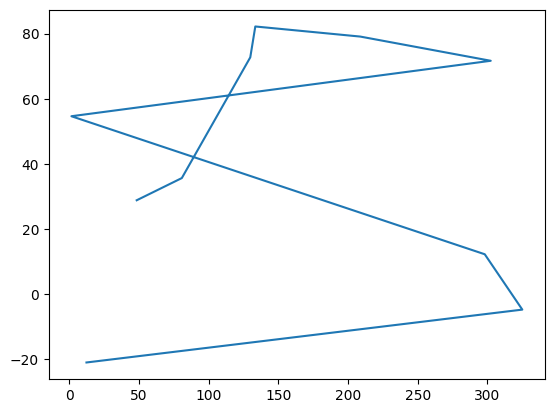

In [38]:
plt.plot(fields["ra"],fields["dec"])

In [89]:
# get column names
q = """
SELECT *
FROM gaiadr3.gaia_source
"""
job = Gaia.launch_job(q)
metadata = job.get_results()

print(metadata.columns)


<TableColumns names=('solution_id','DESIGNATION','SOURCE_ID','random_index','ref_epoch','ra','ra_error','dec','dec_error','parallax','parallax_error','parallax_over_error','pm','pmra','pmra_error','pmdec','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr','astrometric_n_obs_al','astrometric_n_obs_ac','astrometric_n_good_obs_al','astrometric_n_bad_obs_al','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig','astrometric_params_solved','astrometric_primary_flag','nu_eff_used_in_astrometry','pseudocolour','pseudocolour_error','ra_pseudocolour_corr','dec_pseudocolour_corr','parallax_pseudocolour_corr','pmra_pseudocolour_corr','pmdec_pseudocolour_corr','astrometric_matched_transits','visibility_periods_used','astrometric_sigma5d_max','matched_transits','new_matched_transits','matched_transits_removed','ip

In [90]:
# Gaia.query_object_async(coord,width=0.1*u.deg,height=0.1*u.deg)

In [91]:
query

"\nSELECT\n  source_id,\n  ra,\n  dec,\n  phot_g_mean_mag\nFROM\n  gaiadr3.gaia_source\nWHERE\n  1=CONTAINS(\n    POINT('ICRS', ra, dec),\n    CIRCLE('ICRS', 10.684, 41.268, 0.5)\n  )\n  AND phot_g_mean_mag < 11\n"

In [92]:
job = Gaia.launch_job(query)

results = job.get_results()
results

SOURCE_ID,ra,dec,phot_g_mean_mag
,deg,deg,mag
int64,float64,float64,float32
381167803378329088,10.376961823526926,41.0528905965166,10.93436
381258543149352064,10.608749166846083,41.09671184993717,9.483673
381266587637831296,10.537464102530656,41.39182217687905,10.034954
381269027173161088,10.840211624902983,41.36527668632988,10.854134
381271501074306816,10.639534963546817,41.385429522379276,10.83179
381274112414394496,10.756546520254734,41.50204385990195,10.668487
381277514028514304,10.374005961687619,41.369739967377434,9.537494
381285141893198336,10.568254179320162,41.51025612813797,10.752106


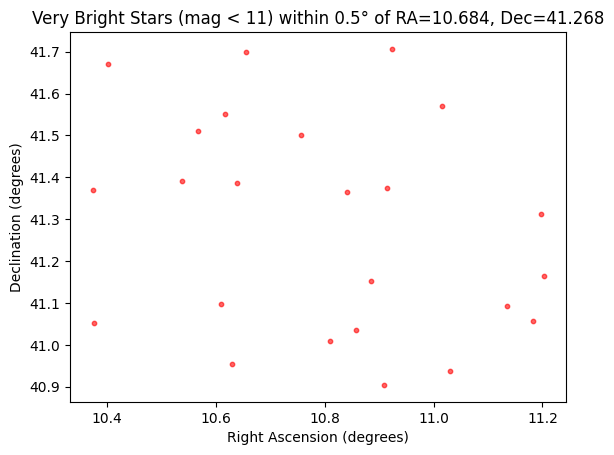

In [93]:
plt.scatter(results['ra'], results['dec'], s=10, color='red', alpha=0.6)
plt.title(f'Very Bright Stars (mag < {MAG_LIM}) within {RADIUS}° of RA={RA}, Dec={DEC}')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()


In [94]:
RESOLUTION = 50

ras = np.linspace(RA-RADIUS,RA+RADIUS, RESOLUTION)
decs = np.linspace(DEC-RADIUS,DEC+RADIUS, RESOLUTION)

nums = np.empty((len(ras),len(decs)))


best_num = 0
best_ra, best_dec = None, None
for i, ra in enumerate(ras):
    for j, dec in enumerate(decs):
        n_in_box = np.sum((results["ra"] >= ra-0.5*FIELD_WIDTH) & (results["ra"] <= ra+0.5*FIELD_WIDTH) & (results["dec"] >= dec-0.5*FIELD_HEIGHT) & (results["dec"] <= dec + 0.5*FIELD_HEIGHT))
        nums[i,j] = n_in_box
        if n_in_box > best_num:
            best_ra = ra
            best_dec = dec
            best_num = n_in_box
best_ra, best_dec, best_num

(np.float64(11.000326530612243), np.float64(41.012897959183675), np.int64(8))

In [95]:
results[(results["ra"] >= best_ra-0.5*FIELD_WIDTH) & (results["ra"] <= best_ra+0.5*FIELD_WIDTH) & (results["dec"] >= best_dec-0.5*FIELD_HEIGHT) & (results["dec"] <= best_dec + 0.5*FIELD_HEIGHT)]

SOURCE_ID,ra,dec,phot_g_mean_mag
,deg,deg,mag
int64,float64,float64,float32
369232291123186688,10.909879256624698,40.90415281643903,9.885935
369235112920315648,11.029861579618807,40.93839714181129,10.982586
369237586821696128,11.183230847231407,41.0566738055059,10.329876
369240782277358464,11.134776613273765,41.09253517966223,10.278439
369245111604163072,10.808943579377981,41.00948125173388,8.921322
369245558280757632,10.856731786154326,41.035158772081886,10.512143
369253147484361984,10.885911917992653,41.152509062684395,10.492693
369264554917499520,11.202186469091936,41.16331529690814,10.478035


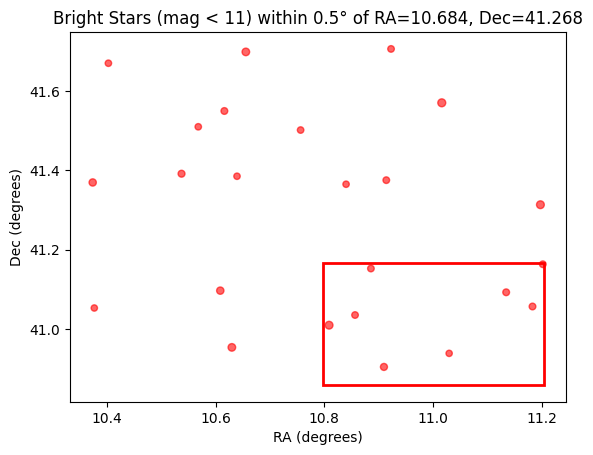

In [106]:
# Create a 2D histogram for density visualization
plt.scatter(results['ra'], results['dec'], s=(50/results["phot_g_mean_mag"])**2, color='red', alpha=0.6)
plt.gca().add_patch(Rectangle((best_ra-FIELD_WIDTH/2, best_dec-FIELD_HEIGHT/2), FIELD_WIDTH, FIELD_HEIGHT, linewidth=2, edgecolor='red', facecolor='none'))
# plt.colorbar(label='Star Density')
plt.title(f'Bright Stars (mag < {MAG_LIM}) within {RADIUS}° of RA={RA}, Dec={DEC}')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.show()


In [100]:
query_size = 0.
min_ra, min_dec

NameError: name 'min_ra' is not defined

In [9]:
import os

In [10]:
dir = r"C:\Users\chell\PycharmProjects\alora\alora\observatory\bin"

prefiles = set(os.listdir(dir))

        


In [12]:
img = prefiles - set(os.listdir(dir))
img

set()

In [13]:
os.listdir(dir)

['close.py',
 'hi.txt',
 'home.py',
 'identify_bright_fields.ipynb',
 'open.py',
 'park.py',
 'pointing_model.py',
 'slew_to.py',
 'solve.py',
 'take_images.py']

In [16]:
[f for f in os.listdir(dir) if f not in prefiles]

['hi.txt']